# Keras various tests


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
import numpy as np

from sklearn.model_selection import train_test_split

Using Theano backend.


## Predictions from zero input or random predictions

Let's consider simple classification problem : $ y = round(x_1 + x_2)$

Then we setup training data to a zero vector and see predictions and model evaluation

In [2]:
nb_samples = 1000
nb_features = 2
nb_classes = 10

while True:
    x = nb_classes*0.5*np.random.random((nb_samples, nb_features))
    y = np.round(np.sum(x, axis=1)) % nb_classes
    if len(np.unique(y)) == nb_classes:
        break

x_train_nonzero, x_val, y_train, y_val = train_test_split(x,y, train_size=0.75)

x_train_zero = np.zeros_like(x_train_nonzero)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


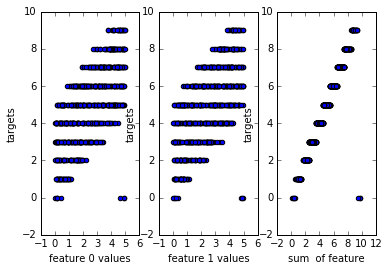

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot(131)
plt.scatter(x_train_nonzero[:, 0], y_train)
plt.xlabel('feature 0 values')
plt.ylabel('targets')
plt.subplot(132)
plt.scatter(x_train_nonzero[:, 1], y_train)
plt.xlabel('feature 1 values')
plt.ylabel('targets')
plt.subplot(133)
plt.scatter(np.sum(x_train_nonzero, axis=1), y_train)
plt.xlabel('sum  of feature')
plt.ylabel('targets')

In [4]:
def create_model():
    model = Sequential()
    model.add(Dense(15, init='uniform', input_shape=(nb_features,), activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

for x_train in [x_train_nonzero, x_train_zero]:

    model = create_model()
    model.summary()

    y_train_ = np_utils.to_categorical(y_train)
    y_val_ = np_utils.to_categorical(y_val)
    
    model.fit(x_train, y_train_, nb_epoch=1000, batch_size=100, verbose=0)
    scores = model.evaluate(x_val, y_val_, verbose=0)
    print "Model Accuracy : %.2f%%" % (scores[1]*100)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 15)            45          dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            160         dense_1[0][0]                    
Total params: 205
____________________________________________________________________________________________________


/usr/local/lib/python2.7/site-packages/keras/utils/np_utils.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/usr/local/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


Model Accuracy : 94.00%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_3 (Dense)                  (None, 15)            45          dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 10)            160         dense_3[0][0]                    
Total params: 205
____________________________________________________________________________________________________
Model Accuracy : 14.80%


Run Cross-Validation with on zero train vector

In [5]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [6]:
estimator = KerasClassifier(build_fn=create_model, nb_epoch=1000, batch_size=100, verbose=0)
dummy_y = np_utils.to_categorical(y)

In [7]:
results = cross_val_score(estimator, x, dummy_y, cv=5)
print("CV on normal data: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

CV on normal data: 94.60% (2.08%)


In [8]:
results = cross_val_score(estimator, np.zeros_like(x), dummy_y, cv=5)
print("CV on zero data: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

CV on zero data: 18.90% (1.62%)


### Compare with random predictions

In [9]:
y_train_ = np_utils.to_categorical(y_train)
estimator.fit(x_train_zero, y_train_)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
max_random_accuracy = 0.0
for i in range(10000):
    y_random_pred = np.random.randint(10, size=(y_val.shape))
    acc = accuracy_score(y_val, y_random_pred)
    if max_random_accuracy < acc:
        max_random_accuracy = acc

y_pred = estimator.predict(x_val)

print max_random_accuracy, accuracy_score(y_val, y_pred)

0.176 0.164


Test with yearmonth

In [1]:
from common import _to_ym_dec, _to_ym, _to_nb_months

In [12]:
ym_ref = 2

for ym in [201504, 201505, 201501, 200001, 1]:
    print ym, _to_ym_dec(ym), _to_ym_dec(ym) - _to_ym_dec(ym_ref), _to_ym(_to_ym_dec(ym) - _to_ym_dec(ym_ref))


201504 2015.25 2015.16666667 201503
201505 2015.33333333 2015.25 201504
201501 2015.0 2014.91666667 201412
200001 2000.0 1999.91666667 199912
1 0.0 -0.0833333333333 1


In [18]:
train_yearmonths_list = [201505, 201506, 201601]

yearmonths_list = []

# train_yearmonths_list should be sorted in ascending order without duplicates
for ym in train_yearmonths_list + [201605]:
    # get the previous month
    prev_ym = _to_ym(_to_ym_dec(ym) - _to_ym_dec(2))
    if len(yearmonths_list) and yearmonths_list[-1] == prev_ym:
        yearmonths_list += [ym]
    else:
        yearmonths_list += [prev_ym, ym]

print yearmonths_list

[201504, 201505, 201506, 201512, 201601, 201604, 201605]


Append last choice as columns

In [30]:
import numpy as np
import pandas as pd
ll = 5
train_df = pd.DataFrame({'ncodpers': range(ll) + range(ll), 'fecha_dato': [201501]*ll + [201502]*ll, 'a': range(2*ll), 'b': np.random.randn(2*ll)}, columns=['ncodpers', 'fecha_dato', 'a', 'b'])
train_df

,ncodpers,fecha_dato,a,b
0,0,201501,0,-0.421121
1,1,201501,1,-0.140080
2,2,201501,2,-0.072629
3,3,201501,3,0.002414
4,4,201501,4,0.269303
5,0,201502,5,1.199566
6,1,201502,6,0.294741
7,2,201502,7,0.677725
8,3,201502,8,0.827027
9,4,201502,9,0.271020


In [32]:
train_df2 = train_df#.sort_values(['ncodpers', 'fecha_dato'])   

last_choice_mask = train_df2['fecha_dato'] == 201501
train_month_mask = train_df2['fecha_dato'] == 201502

TARGET_LABELS = ['a', 'b']

In [34]:
clients_last_choice = train_df2[last_choice_mask][TARGET_LABELS]#.sort_values(['ncodpers']) 
# Prepend "lc_" to column names
clc_new_cols = clients_last_choice.columns.values
clc_new_cols[:] = "lc_" + clc_new_cols[:]

# Replace indices to the ones corresponding to the current month
clients_last_choice.index = train_df2[train_month_mask].index

train_df3 = pd.concat([train_df2, clients_last_choice], axis=1)
train_df3 = train_df3.sort_values(['ncodpers', 'fecha_dato'])
train_df3

,ncodpers,fecha_dato,a,b,lc_a,lc_b
0,0,201501,0,-0.421121,NaN,NaN
5,0,201502,5,1.199566,0.0,-0.421121
1,1,201501,1,-0.140080,NaN,NaN
6,1,201502,6,0.294741,1.0,-0.140080
2,2,201501,2,-0.072629,NaN,NaN
7,2,201502,7,0.677725,2.0,-0.072629
3,3,201501,3,0.002414,NaN,NaN
8,3,201502,8,0.827027,3.0,0.002414
4,4,201501,4,0.269303,NaN,NaN
9,4,201502,9,0.271020,4.0,0.269303


In [ ]:
def _add_diff_inplace(df, prev_ym_mask, ym_mask):
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'t'] = df[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
#     print tmp_df.sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 't']].head()
    v1 = tmp_df[ym_mask][['ncodpers', 't']]
#     print v1[['ncodpers', 't']].head()
    v2 = tmp_df[prev_ym_mask][['ncodpers', 't']]
#     print v2[['ncodpers', 't']].head()
    assert len(v1) == len(v2), "Length of current month and previous month are not equal"
#     v1.columns = ['ncodpers', 't1']
#     v2.columns = ['ncodpers', 't2']
#     v2.index = v1.index
#     v1.loc[:, 't2'] = v2['t2']
#     df.loc[ym_mask,'diff'] = v1[['t1', 't2']].apply(diff, axis=1)
    v2.index = v1.index
    df.loc[ym_mask,'diff'] = v1['t'] - v2['t']

In [1]:
from dataset import load_trainval
t, v = load_trainval([201504], [201505], 1000)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [2]:
t[['fecha_dato', 'ncodpers','diff']].head()

,fecha_dato,ncodpers,diff
420826,2015-03-28,17964,-16777216
838817,2015-04-28,17964,0
422436,2015-03-28,19014,-16777216
840662,2015-04-28,19014,0
422707,2015-03-28,19919,-16777216


In [3]:
v[['fecha_dato', 'ncodpers','diff']].head()

,fecha_dato,ncodpers,diff
0,2015-04-28,15889,-16777216
1262322,2015-05-28,15889,32
210123,2015-04-28,15890,-16777216
1262323,2015-05-28,15890,0
210122,2015-04-28,15892,-16777216


In [ ]:
# def load_trainval(train_yearmonths_list, val_yearmonth, train_nb_clients=-1):

train_yearmonths_list = [201505, 201506]
val_yearmonth = [201605]
train_nb_clients = 1000

In [ ]:
def _get_prev_ym(ym):
    return _to_ym(_to_ym_dec(ym) - _to_ym_dec(2))

def _ym_list_to_load(ym_list):
    """
    Append previous month to the each yearmonth
    """
    out = []
    for ym in ym_list:
        # get the previous month
        prev_ym = _get_prev_ym(ym)
        if len(out) and out[-1] == prev_ym:
            out += [ym]
        else:
            out += [prev_ym, ym]
    return out

yearmonth_list = _ym_list_to_load(train_yearmonths_list)
print "Load yearmonth_list", yearmonth_list
train_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, train_nb_clients)
minimal_clean_data_inplace(train_df)
preprocess_data_inplace(train_df)

months = train_df['fecha_dato'].unique()
clients = train_df['ncodpers'].unique()
assert len(clients) == (train_df['ncodpers'].value_counts() == len(yearmonth_list)).sum()
ll = len(clients)
months_ym_map = {}
for m in months:
    l = len(train_df[train_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)
    months_ym_map[to_yearmonth(m)] = m

In [ ]:
print months, months_ym_map

In [ ]:
from math import log


LC_TARGET_LABELS = ['lc_' + t for t in TARGET_LABELS]        


def dummies_to_str(row):
    output = ''
    for v in row.values:
        output += str(int(v))
    return output


def dummies_to_decimal(row):
    output = dummies_to_str(row)
    return int(output, 2)

    
def _add_diff_inplace(df, prev_ym_mask, ym_mask):
    """
    df should be imperatively sorted by clients in order to subtract and assign correctly
    """
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'t'] = df[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
    v1 = tmp_df[ym_mask][['ncodpers', 't']]
    v2 = tmp_df[prev_ym_mask][['ncodpers', 't']]
    assert len(v1) == len(v2), "Length of current month and previous month are not equal"
    v2.index = v1.index
    df.loc[ym_mask,'diff'] = v1['t'] - v2['t']
    
    
def _add_clc_inplace(df, prev_ym_mask, ym_mask):
    """
    df should be imperatively sorted by clients in order to subtract and assign correctly
    """
    clients_last_choice = df[prev_ym_mask][['ncodpers'] + TARGET_LABELS]
#     print clients_last_choice[['ncodpers'] + TARGET_LABELS[:1]].head()
    # Prepend "lc_" to column names
    clc_new_cols = clients_last_choice.columns.values
    clc_new_cols[1:] = "lc_" + clc_new_cols[1:]
    
    clients_last_choice.index = df[ym_mask].index
    for c in clc_new_cols[1:]:
        df.loc[ym_mask, c] = clients_last_choice[c]

    df.loc[ym_mask, 'lc_targets_str'] = df[ym_mask][LC_TARGET_LABELS].apply(dummies_to_str, axis=1)
    df.loc[ym_mask, 'lc_targets_dec'] = df[ym_mask][LC_TARGET_LABELS].apply(dummies_to_decimal, axis=1)


# Imperatively sort by clients in order to subtract and assign correctly
train_df2 = train_df.sort_values(['ncodpers', 'fecha_dato'])    

for ym in train_yearmonths_list:
    prev_ym = _get_prev_ym(ym)
    prev_ym_mask = train_df2['fecha_dato'] == months_ym_map[prev_ym]
    ym_mask = train_df2['fecha_dato'] == months_ym_map[ym]

    train_df2.loc[:, 'targets_str'] = train_df2[TARGET_LABELS].apply(dummies_to_str, axis=1)
    train_df2.loc[:, 'targets_dec'] = train_df2[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
    
    _add_diff_inplace(train_df2, prev_ym_mask, ym_mask)
    _add_clc_inplace(train_df2, prev_ym_mask, ym_mask)


mask = (~train_df2['diff'].isnull())
assert (train_df2[mask]['diff'] == train_df2[mask]['targets_dec'] - train_df2[mask]['lc_targets_dec']).all(), "Something is wrong"


In [ ]:
mask = (~train_df2['diff'].isnull()) & (train_df2['diff'] != 0.0)
train_df2[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_dec', 'diff', 'lc_targets_str', 'lc_targets_dec']].head(10)


In [ ]:
yearmonth_list = _ym_list_to_load(val_yearmonth)
print "Load yearmonth_list", yearmonth_list
val_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, 'max')
minimal_clean_data_inplace(val_df)
preprocess_data_inplace(val_df)

In [ ]:
months = val_df['fecha_dato'].unique()
clients = val_df['ncodpers'].unique()
assert len(clients) == (val_df['ncodpers'].value_counts() == len(yearmonth_list)).sum()
ll = len(clients)
months_ym_map = {}
for m in months:
    l = len(val_df[val_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)
    months_ym_map[to_yearmonth(m)] = m

In [ ]:
print months, months_ym_map

In [ ]:
# Imperatively sort by clients in order to subtract and assign correctly
val_df2 = val_df.sort_values(['ncodpers', 'fecha_dato'])    

for ym in val_yearmonth:
    prev_ym = _get_prev_ym(ym)
    prev_ym_mask = val_df2['fecha_dato'] == months_ym_map[prev_ym]
    ym_mask = val_df2['fecha_dato'] == months_ym_map[ym]

    val_df2.loc[:, 'targets_str'] = val_df2[TARGET_LABELS].apply(dummies_to_str, axis=1)
    val_df2.loc[:, 'targets_dec'] = val_df2[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
    
    _add_diff_inplace(val_df2, prev_ym_mask, ym_mask)
    _add_clc_inplace(val_df2, prev_ym_mask, ym_mask)


mask = (~val_df2['diff'].isnull())
assert (val_df2[mask]['diff'] == val_df2[mask]['targets_dec'] - val_df2[mask]['lc_targets_dec']).all(), "Something is wrong"


In [ ]:
mask = (~val_df2['diff'].isnull()) & (val_df2['diff'] != 0.0)
val_df2[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_dec', 'diff', 'lc_targets_str', 'lc_targets_dec']].head(10)


In [ ]:
mask = val_df2['fecha_dato'] == months_ym_map[201605]
val_df2[mask].shape

In [ ]:
full_val_df = load_data2(TRAIN_FILE_PATH, [201605])
minimal_clean_data_inplace(full_val_df)
preprocess_data_inplace(full_val_df)

In [ ]:
full_val_df.shape

In [41]:
output = '0101'
res = int(output, 2)
print res
print bin(res)



5
0b101


In [158]:
import numpy as np

def dummy_to_dec(s):
    v = 0
    for i, c in enumerate(s):
        v += np.power(0.5, i) * int(c)
    return v

output = '110000001011010000000001'
res = dummy_to_dec(output)
print res

def dec_to_dummy(v):
    q=0.5
    output = '{:024b}'.format(int(v/(q**23)))
    return output

print dec_to_dummy(res)
print output




1.50549328327
110000001011010000000001
110000001011010000000001


Conversion formula is the following: $|q| < 1$

$$v = c_0 + q^1 c_1 + q^2 c_2 + ... + q^n c_n$$

v/q^n = c_0/q^n + c_1/q^{n-1} + ... + c_n


$$\frac{v}/{q} = c_0 / q + c_1 + q^1 c_2 + ... + q^{n-1} c_n $$


(v - c_0)/q = c_1 + q^1 c_2 + ... + q^{n-1} c_n = w_1

c_0 = v - w_1 q
c_1 = w_1 - w_2 q, w_2 = c_2 + q^1 c_3 + ... + q^{n-2} c_n
c_{n-1} = w_{n-1} - w_n q, w_n = c_n 


$$log(v)/log(q^0) = log(q^0 c_0) / log(q^0) log(q^1 c_1) log(q^2 c_2) ...$$



In [124]:
q = 0.5
qs = np.power(q, np.arange(0,24,1))
print qs, qs.sum()

qs / q**23

[  1.00000000e+00   5.00000000e-01   2.50000000e-01   1.25000000e-01
   6.25000000e-02   3.12500000e-02   1.56250000e-02   7.81250000e-03
   3.90625000e-03   1.95312500e-03   9.76562500e-04   4.88281250e-04
   2.44140625e-04   1.22070312e-04   6.10351562e-05   3.05175781e-05
   1.52587891e-05   7.62939453e-06   3.81469727e-06   1.90734863e-06
   9.53674316e-07   4.76837158e-07   2.38418579e-07   1.19209290e-07] 1.99999988079


array([  8.38860800e+06,   4.19430400e+06,   2.09715200e+06,
         1.04857600e+06,   5.24288000e+05,   2.62144000e+05,
         1.31072000e+05,   6.55360000e+04,   3.27680000e+04,
         1.63840000e+04,   8.19200000e+03,   4.09600000e+03,
         2.04800000e+03,   1.02400000e+03,   5.12000000e+02,
         2.56000000e+02,   1.28000000e+02,   6.40000000e+01,
         3.20000000e+01,   1.60000000e+01,   8.00000000e+00,
         4.00000000e+00,   2.00000000e+00,   1.00000000e+00])

7340032.0



'011100000000000000000000'

In [22]:
(0.5**10 - 1)/(0.5 - 1)

1.998046875